In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from patsy import dmatrices
import statsmodels.api as sm
from pandas.plotting import lag_plot

In [33]:
data = main.getdata('data/timeseries9May.csv')

In [34]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [35]:
len(data['country'].unique())

10

In [36]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
11142,2019-12-31,31,12,2019,0,0,Norway,NO,NOR,5314336.0,Europe
5790,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe
1675,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe
12247,2019-12-31,31,12,2019,0,0,Romania,RO,ROU,19473936.0,Europe
15234,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe


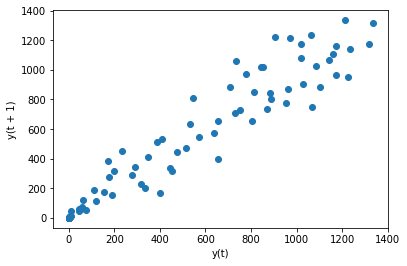

In [37]:
lag_plot(data.loc[data['country']=='Netherlands', 'cases'])
plt.show()

Add columns for cases of yesterday and predictions of yesterday. 

In [38]:
data = data.assign(expcasesyest=np.nan, casesyest=np.nan)

In [39]:
for country in data['country'].unique(): 
    data.loc[data['country']==country, 'casesyest'] = data.loc[data['country']==country].cases.shift(1)

In [41]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesyest,casesyest
11142,2019-12-31,31,12,2019,0,0,Norway,NO,NOR,5314336.0,Europe,NaN,0.0
5790,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe,NaN,0.0
1675,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe,NaN,0.0
12247,2019-12-31,31,12,2019,0,0,Romania,RO,ROU,19473936.0,Europe,NaN,0.0
15234,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe,NaN,0.0


Separate countries, reindex dataframes and set the first expcasesyest to 0. 

In [42]:
nl = data.loc[data['country'] == 'Netherlands']
no = data.loc[data['country'] == 'Norway']
be = data.loc[data['country'] == 'Belgium']
ge = data.loc[data['country'] == 'Germany']
de = data.loc[data['country'] == 'Denmark']
se = data.loc[data['country'] == 'Sweden']
ro = data.loc[data['country'] == 'Romania']
it = data.loc[data['country'] == 'Italy']
uk = data.loc[data['country'] == 'United_Kingdom']
sp = data.loc[data['country'] == 'Spain']

In [43]:
nl.drop(nl.loc[nl['cases']==0].index, inplace=True)
no.drop(no.loc[no['cases']==0].index, inplace=True)
be.drop(be.loc[be['cases']==0].index, inplace=True)
ge.drop(ge.loc[ge['cases']==0].index, inplace=True)
de.drop(de.loc[de['cases']==0].index, inplace=True)
se.drop(se.loc[se['cases']==0].index, inplace=True)
ro.drop(ro.loc[ro['cases']==0].index, inplace=True)
it.drop(it.loc[it['cases']==0].index, inplace=True)
uk.drop(uk.loc[uk['cases']==0].index, inplace=True)
sp.drop(sp.loc[sp['cases']==0].index, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [44]:
nl.reset_index(drop=True, inplace=True)
no.reset_index(drop=True, inplace=True)
be.reset_index(drop=True, inplace=True)
ge.reset_index(drop=True, inplace=True)
de.reset_index(drop=True, inplace=True)
se.reset_index(drop=True, inplace=True)
ro.reset_index(drop=True, inplace=True)
it.reset_index(drop=True, inplace=True)
uk.reset_index(drop=True, inplace=True)
sp.reset_index(drop=True, inplace=True)

In [45]:
nl.loc[0,'expcasesyest']=0
no.loc[0,'expcasesyest']=0
be.loc[0,'expcasesyest']=0
ge.loc[0,'expcasesyest']=0
de.loc[0,'expcasesyest']=0
se.loc[0,'expcasesyest']=0
ro.loc[0,'expcasesyest']=0
it.loc[0,'expcasesyest']=0
uk.loc[0,'expcasesyest']=0
sp.loc[0,'expcasesyest']=0

Regression model based on https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958 and http://economiaweb.unipv.it/wp-content/uploads/2018/01/DEMWP0185.pdf. 

In [55]:
expr = """cases ~  (np.log(1+casesyest)) + (np.log(1+expcasesyest))"""
for i in range(1, len(nl)): 
    mask = np.full(len(nl), False)
    mask[(i-1):i] = True
    df_train = nl[mask]
    y_train, X_train = dmatrices(expr, nl[mask], return_type='dataframe')
    
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    
    poisson_predictions = poisson_training_results.get_prediction(X_train)
    predictions_summary_frame = poisson_predictions.summary_frame()
    nl.loc[i,'expcasesyest']=int(predictions_summary_frame['mean'].values[0])

In [51]:
nl.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesyest,casesyest
0,2020-02-28,28,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
1,2020-02-29,29,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe,1.0,1.0
2,2020-03-01,1,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe,1.0,1.0
3,2020-03-02,2,3,2020,6,0,Netherlands,NL,NLD,17231017.0,Europe,5.0,5.0
4,2020-03-03,3,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe,5.0,6.0


In [52]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                    1
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.9793
Date:                Tue, 12 May 2020   Deviance:                   1.0081e-13
Time:                        18:56:36   Pearson chi2:                 4.54e-28
No. Iterations:                     1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Next steps:
* Append prediction as column?
* Extract coefficients at each timestep so that we can visualize the development of the coefficients. 
* Plot daily predictions and true cases (expcasesyest and casesyest + manual for last datapoint)